In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder ()
from tqdm import tqdm
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam 
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import sklearn 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

2.8.0


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## feature extraction function

In [2]:
n_fft=1024,
hop_length=512
def feature_extracter(file):
    y,sr = librosa.load(file,res_type='kaiser_fast')
    ######## spectral features
    mfcc_feature = librosa.feature.mfcc(y = y ,sr = sr, n_mfcc = 12)
#     print(mfcc_feature.shape)
    cqt_feature = librosa.feature.chroma_cqt(y = y, sr= sr, hop_length = 512, n_chroma= 12)
#     print(cqt_feature.shape)
    zcr_feature = librosa.feature.zero_crossing_rate(y= y)
#     print(zcr_feature.shape)
    contrast =  librosa.feature.spectral_contrast(y=y, sr=sr)
#     print(contrast.shape)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
#     print(bandwidth.shape)
    flatness = librosa.feature.spectral_flatness(y= y)
#     print(flatness.shape)
    rolloff =librosa.feature.spectral_rolloff(y=y, sr=sr)
    
    ### rhythmic features
    
    hop_length = 512
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr,hop_length=hop_length)
    # Compute the auto-correlation tempogram, unnormalized to make comparison easier
    ac_tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=hop_length, norm=None)
    ac_tempogram = np.mean(ac_tempogram,axis = 0)
    ac_tempogram = ac_tempogram.reshape(1,-1)
    ######## beats and tempo 
    tempo= librosa.beat.tempo(y=y, sr=sr)
    feature = np.concatenate((mfcc_feature,cqt_feature,zcr_feature,contrast,bandwidth, flatness, rolloff,ac_tempogram),axis = 0)
    feature = np.mean(feature.T,axis = 0)
    feature = np.concatenate((feature, tempo),axis = 0)
    return feature

## confusion matrix function

In [3]:
def plot_confusion_matrix(cm, classes,normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30,fontweight="bold")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20,fontweight="bold")
    plt.xlabel('Predicted label',fontsize=20,fontweight="bold")

### labeling and creating data csv 

In [128]:
genres  =['blues', 'classical', 'country','disco', 'hiphop','jazz', 'metal','pop','reggae','rock']
path = "F:/iisc/MLSP/project mlsp/genres"
data=[]
labels = []
for i,genre in enumerate(genres):
    genre_path= path + '/'+genre
    for file in tqdm(os.listdir(genre_path)):
        file_path = genre_path +'/'+file
        feature = feature_extracter(file_path)
#         mfcc_delta = librosa.feature.delta(mfcc,order = 2)
        labels.append(i)
        data.append(feature)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:00<00:00,  2.41s/it]


In [130]:
import csv
df = pd.DataFrame(data)
df.to_csv('F:/iisc/MLSP/project mlsp/final_input_file.csv')

### to read from csv
dont run above cell read input csv  - final_input_file_final.csv

In [4]:
genres  =['blues', 'classical', 'country','disco', 'hiphop','jazz', 'metal','pop','reggae','rock']
path = "F:/iisc/MLSP/project mlsp/genres"
labels = []
for i,genre in enumerate(genres):
    genre_path= path + '/'+genre
    for file in tqdm(os.listdir(genre_path)):
        labels.append(i)
df = pd.read_csv('F:/iisc/MLSP/project mlsp/final_input_file_final.csv',header = None)
data = np.array(df)

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


### shuffle tha data

In [6]:
labels = np.array(labels)
data =np.array(data)
idx = list(range(data.shape[0]))
np.random.shuffle(idx)
data_shuffled = data[idx,:]
labels_shuffled = labels[idx]
labels_shuffled.shape
data.shape

(1000, 37)

In [7]:
X_train, X_test,y_train, y_test = train_test_split(data_shuffled, labels_shuffled ,test_size =0.20 ,shuffle = True)

## SVM

In [12]:
svX_train, svX_test,svy_train, svy_test = train_test_split(data_shuffled, labels_shuffled ,test_size =0.20 ,shuffle = True)

In [13]:
svm_model = SVC(kernel = 'linear', C=15,tol = 0.01)
svm_model.fit(svX_train, svy_train)
svy_pred =svm_model.predict(svX_test)
svm_model.score(svX_test,svy_test)

0.695

Normalized confusion matrix


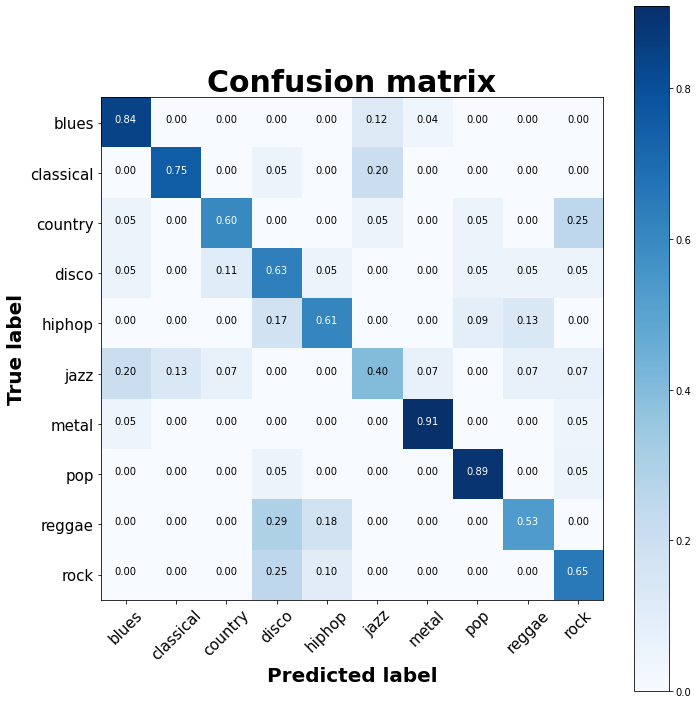

In [14]:
cm= confusion_matrix(svy_test, svy_pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,genres,True)

## LDA

In [29]:
ldX_train, ldX_test,ldy_train, ldy_test = train_test_split(data_shuffled, labels_shuffled ,test_size =0.20 ,shuffle = True)

In [30]:
model = LinearDiscriminantAnalysis(solver= 'svd',tol = 0.01)
model.fit(ldX_train, ldy_train)
ldy_pred = model.predict(ldX_test)
model.score(ldX_test,ldy_test)

0.765

Normalized confusion matrix


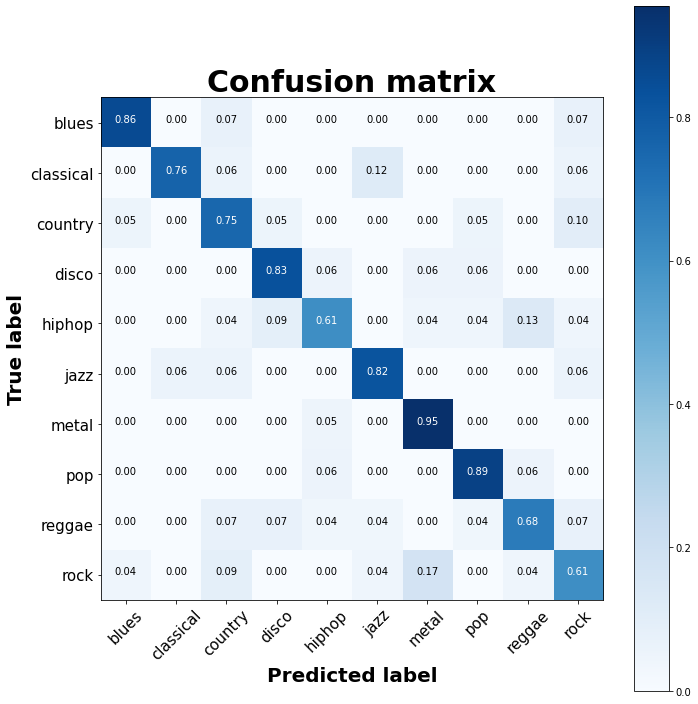

In [31]:
cm= confusion_matrix(ldy_test, ldy_pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,genres,True)

## ANN

In [175]:
label_encoder= to_categorical(labelencoder.fit_transform(labels_shuffled))
X_train, X_test,y_train, y_test = train_test_split(data_shuffled, label_encoder ,test_size =0.20 ,shuffle = True)
label_encoder.shape
data_shuffled.shape
num_labels= 10

In [176]:
model = Sequential()
##1st layer
model.add(Dense(128,input_shape =(37,)))
model.add(Activation('relu'))
# model.add(Dropout(0.3))

##2nd layer
model.add(Dense(256))
model.add(Activation('relu'))
# model.add(Dropout(0.3))
##3rd layer
model.add(Dense(128))
model.add(Activation('relu'))
# model.add(Dropout(0.3))

##4th layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [177]:
model.summary()
model.compile(loss = 'categorical_crossentropy',metrics = ['accuracy'], optimizer = 'adam')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               4864      
                                                                 
 activation_28 (Activation)  (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               33024     
                                                                 
 activation_29 (Activation)  (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 activation_30 (Activation)  (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 10)               

In [180]:
num_epochs = 200
num_batch_size = 64
checkpointer = ModelCheckpoint(filepath= 'saved_models/audio_classification.hdf5', verbose = 1, save_best_only = True)
start = datetime.now()
model.fit(X_train,y_train, batch_size= num_batch_size, epochs= num_epochs,callbacks = [checkpointer])
duration = datetime.now() - start
print("training completed in time:", duration)

Epoch 1/200
13/13 [==============================] - 0s 5ms/step - loss: 0.5760 - accuracy: 0.8087
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.5556 - accuracy: 0.8075
Epoch 3/200
13/13 [==============================] - 0s 6ms/step - loss: 0.4246 - accuracy: 0.8325
Epoch 4/200
13/13 [==============================] - 0s 6ms/step - loss: 0.3271 - accuracy: 0.8888
Epoch 5/200
13/13 [==============================] - 0s 6ms/step - loss: 0.3305 - accuracy: 0.8763
Epoch 6/200
13/13 [==============================] - 0s 6ms/step - loss: 0.4259 - accuracy: 0.8425
Epoch 7/200
13/13 [==============================] - 0s 6ms/step - loss: 0.4084 - accuracy: 0.8462
Epoch 8/200
13/13 [==============================] - 0s 6ms/step - loss: 0.3984 - accuracy: 0.8450
Epoch 9/200
13/13 [==============================] - 0s 5ms/step - loss: 0.4227 - accuracy: 0.8525
Epoch 10/200
13/13 [==============================] - 0s 6ms/step - loss: 0.3357 - accuracy: 0.8712
Epoch 11/

In [181]:
predicted_labels = model.predict(X_test)
pred_labels = []
true_labels = []
for i in range(predicted_labels.shape[0]):
    pred_labels.append(np.argmax(predicted_labels[i,:]))
    true_labels.append(np.argmax(y_test[i,:]))
    
print(pred_labels)
print(true_labels)
def accuracy(y_pred, y_test):
    cnt = 0
    for i in range(len(y_pred)):
        if y_test[i] == y_pred[i]:
            cnt+=1
    accuracy = (cnt/len(y_pred))*100
    return accuracy
accuracy(pred_labels,true_labels)

[0, 9, 4, 1, 3, 6, 1, 8, 0, 2, 3, 6, 7, 0, 6, 1, 7, 7, 6, 8, 3, 4, 2, 8, 2, 3, 2, 0, 4, 3, 7, 3, 0, 6, 4, 4, 6, 3, 0, 2, 8, 8, 8, 8, 0, 6, 9, 9, 3, 7, 4, 6, 4, 1, 0, 3, 7, 4, 3, 8, 2, 4, 8, 9, 7, 1, 7, 8, 8, 0, 6, 3, 3, 7, 3, 3, 0, 8, 9, 8, 6, 7, 5, 6, 6, 8, 6, 4, 3, 3, 8, 4, 7, 8, 6, 5, 2, 0, 8, 9, 4, 7, 2, 1, 5, 2, 9, 9, 1, 6, 8, 3, 0, 4, 5, 1, 2, 3, 4, 7, 4, 0, 0, 0, 1, 1, 2, 5, 1, 5, 1, 8, 6, 6, 0, 6, 2, 5, 6, 0, 4, 2, 2, 6, 8, 6, 3, 4, 8, 8, 1, 0, 7, 9, 1, 7, 6, 6, 5, 2, 4, 8, 5, 7, 8, 6, 8, 8, 0, 3, 4, 3, 4, 7, 7, 0, 6, 1, 5, 8, 6, 7, 9, 5, 4, 7, 1, 4, 6, 7, 4, 5, 6, 9, 8, 6, 7, 1, 9, 2]
[0, 9, 4, 5, 3, 9, 1, 8, 9, 2, 4, 6, 7, 0, 6, 1, 7, 7, 6, 8, 2, 3, 5, 8, 2, 3, 8, 0, 4, 2, 8, 3, 8, 6, 7, 4, 6, 3, 0, 0, 4, 5, 9, 4, 0, 0, 9, 0, 3, 7, 4, 6, 4, 1, 0, 3, 7, 8, 4, 8, 2, 9, 0, 0, 3, 1, 8, 4, 4, 0, 6, 3, 3, 7, 9, 3, 0, 3, 9, 1, 6, 8, 0, 9, 6, 8, 0, 3, 3, 3, 8, 4, 7, 8, 6, 3, 9, 0, 9, 9, 4, 7, 4, 1, 9, 2, 3, 9, 1, 6, 3, 3, 0, 4, 5, 1, 2, 8, 4, 7, 3, 0, 2, 5, 1, 5, 5, 5, 1, 5, 1, 8, 0,

64.5

Normalized confusion matrix


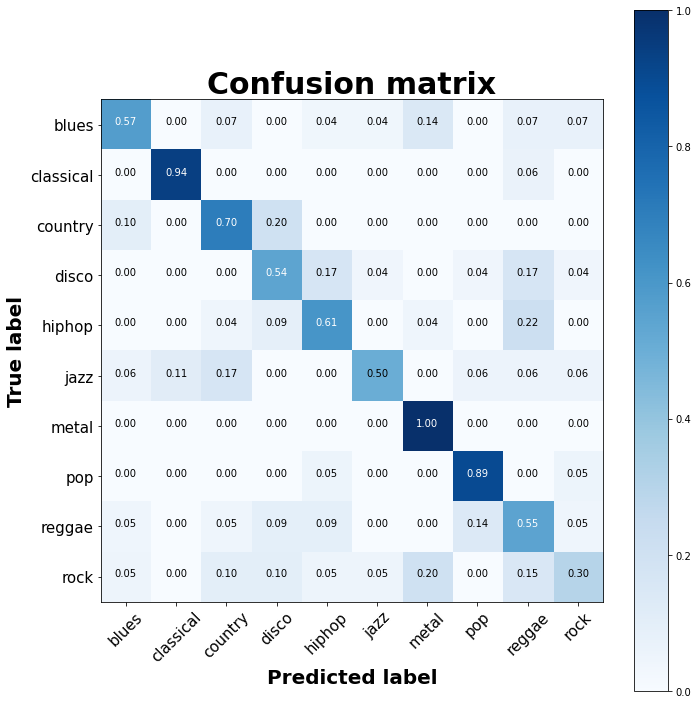

In [182]:
cm= confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,genres,True)

## Random Forest

In [157]:
rfX_train, rfX_test,rfy_train, rfy_test = train_test_split(data_shuffled, labels_shuffled ,test_size =0.20 ,shuffle = True)

sc_X = StandardScaler()
rfX_train = sc_X.fit_transform(rfX_train)
rfX_test = sc_X.transform(rfX_test)

classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 0)
classifier.fit(rfX_train,rfy_train)

rfy_pred = classifier.predict(rfX_test)
classifier.score(rfX_test,rfy_test)

0.75

Normalized confusion matrix


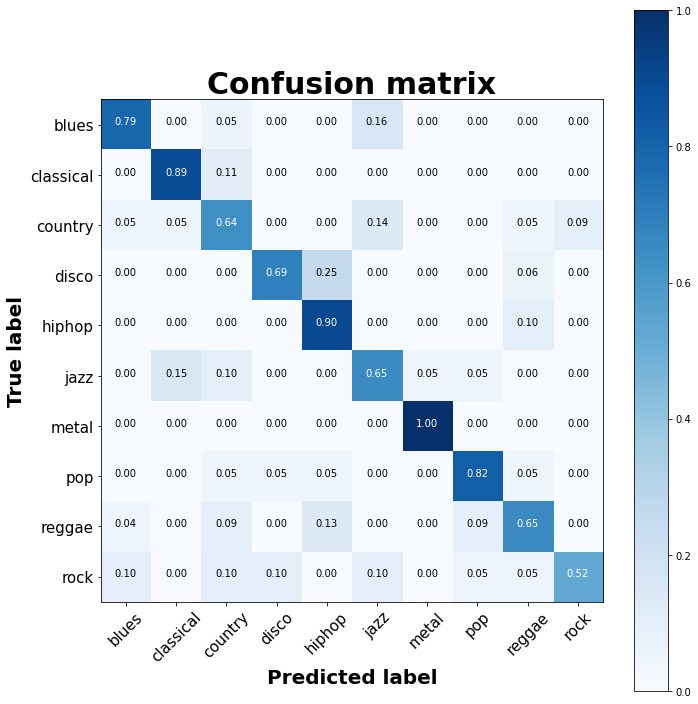

In [158]:
cm= confusion_matrix(rfy_test, rfy_pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,genres,True)

## XG boost

In [184]:
xgX_train, xgX_test,xgy_train, xgy_test = train_test_split(data_shuffled, labels_shuffled ,test_size =0.20 ,shuffle = True)

In [186]:
xg = xgb.XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=4,min_child_weight=6,gamma=0, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27 )
xg.fit(xgX_train,xgy_train)
xgy_pred = xg.predict(xgX_test)
xg.score(xgX_test,xgy_test)

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:14:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.75

Normalized confusion matrix


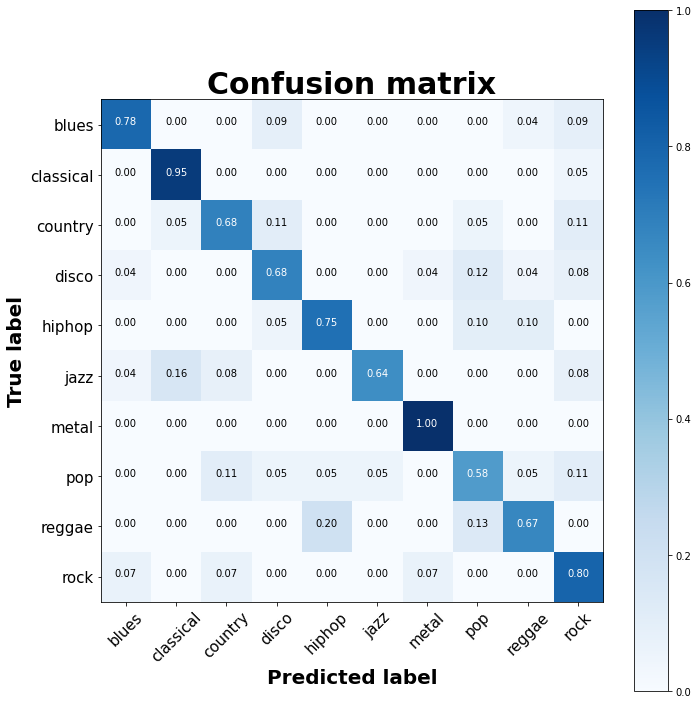

In [187]:
cm= confusion_matrix(xgy_test, xgy_pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,genres,True)

## KNN

In [226]:
knnX_train, knnX_test,knny_train, knny_test = train_test_split(data_shuffled, labels_shuffled ,test_size =0.20 ,shuffle = True)

In [227]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(knnX_train, knny_train)
knny_pred = knn.predict(knnX_test)
print("Accuracy:",metrics.accuracy_score(knny_test, knny_pred))

Accuracy: 0.41


## Gaussian Naive Bayes

In [234]:
gbX_train, gbX_test,gby_train, gby_test = train_test_split(data_shuffled, labels_shuffled ,test_size =0.20 ,shuffle = True)

In [238]:
gnb = GaussianNB()
gby_pred = gnb.fit(gbX_train, gby_train).predict(gbX_test)
print("Number of mislabeled points out of a total %d points : %d"% (gbX_test.shape[0], (gby_test != gby_pred).sum()))
gnb.score(gbX_test,gby_test)

Number of mislabeled points out of a total 200 points : 95


0.525

Normalized confusion matrix


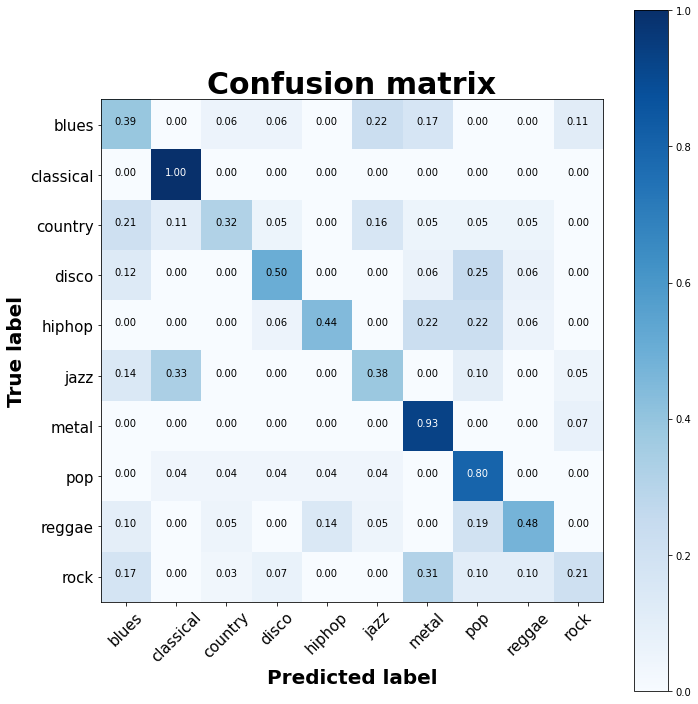

In [236]:
cm= confusion_matrix(gby_test, gby_pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,genres,True)

## DNN+ other classifier

In [ ]:
# features_layer1 = tf.keras.models.Model(
#     inputs=model.inputs,
#     outputs=model.get_layer(name="final_layer").output,
# )
# hidden_layer_features =features_layer1(X_train)
# test_features = features_layer1(X_test)
# print( features_layer1(X_train))

In [ ]:
# newX = np.array(hidden_layer_features)
# new_test = np.array(test_features)

In [ ]:
# svm_model = SVC(kernel = 'linear', C=15,tol = 0.01)
# svm_model.fit(newX, true_train_labels)
# svy_pred =svm_model.predict(new_test)
# svm_model.score(new_test,true_labels)

In [ ]:
# model = LinearDiscriminantAnalysis(solver= 'svd',tol = 0.01)
# model.fit(newX, true_train_labels)
# ldy_pred = model.predict(new_test)
# model.score(new_test,true_labels)